In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [41]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)  # might have zero in the denominator
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_regression(pred_batch, truth_batch, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)\
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            if debug:
                print(pred, truth)
            pred_x, pred_y = pred[0], pred[1]
            true_x, true_y = truth[0], truth[1]
            error.append(Utility.distance_error((pred_x, pred_y), (true_x, true_y)))
        return error

# 1 Regression -- output layer is a FC with two nodes

Note: don't use np.savetxt and np.loadtxt, use np.save and np.load instead. I/O in binary format is faster (almost 10x) than text format, and don't have the utf-8 encoding issue.

Assumption: Training sample increase linear with # TX, not exponential, with the CNN regression

In [37]:
# data

class SensorInputDatasetRegression(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, grid_len: int, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label(os.path.join(self.root_dir, '(0, 0)'))
        self.grid_len = grid_len

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder   = self.oneDint2twoDstr(int(idx/self.sample_per_label))
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        label_arr = self.twoDstr2regreOutput(folder)
        label_arr = self.min_max_normalize(label_arr)
        sample = {'matrix':matrix, 'label':label_arr}
        return sample

    def get_sample_per_label(self, folder: str):
        samples = glob.glob(os.path.join(folder, '*.npy'))
        return len(samples)
    
    def oneDint2twoDstr(self, oneDint: int):
        '''convert a one dimension integer index to a two dimension string index'''
        x = oneDint // Default.grid_length
        y = oneDint %  Default.grid_length
        return f'({x}, {y})'

    def twoDstr2regreOutput(self, twoDstr: str):
        '''convert a two dimension string to the output for regression -- two nodes'''
        twoDstr = twoDstr[1:-1]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        arr = np.array([x, y])
        return arr.astype(np.float32)
    
    def min_max_normalize(self, label_arr: np.ndarray):
        '''scale the localization to a range of (0, 1)
        '''
        label_arr /= self.grid_len
        return label_arr
    
    def undo_normalize(self, arr: np.ndarray):
        arr *= self.grid_len
        return arr


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
indx = 1000
root_dir = './data/matrix-train3'
sensor_input_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[indx]['matrix'].shape)
print(sensor_input_dataset[indx]['label'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test3'
sensor_input_test_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[indx]['matrix'].shape)
print(sensor_input_test_dataset[indx]['label'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[0.01 0.  ]
100000
torch.Size([1, 100, 100])
[0.03 0.33]
30000


In [35]:
class Net3(nn.Module):
    '''the output of the fully connected layer is 1x2 array
       assume the input matrix is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1   = nn.Linear(2592, 100)
        self.fc2   = nn.Linear(100, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

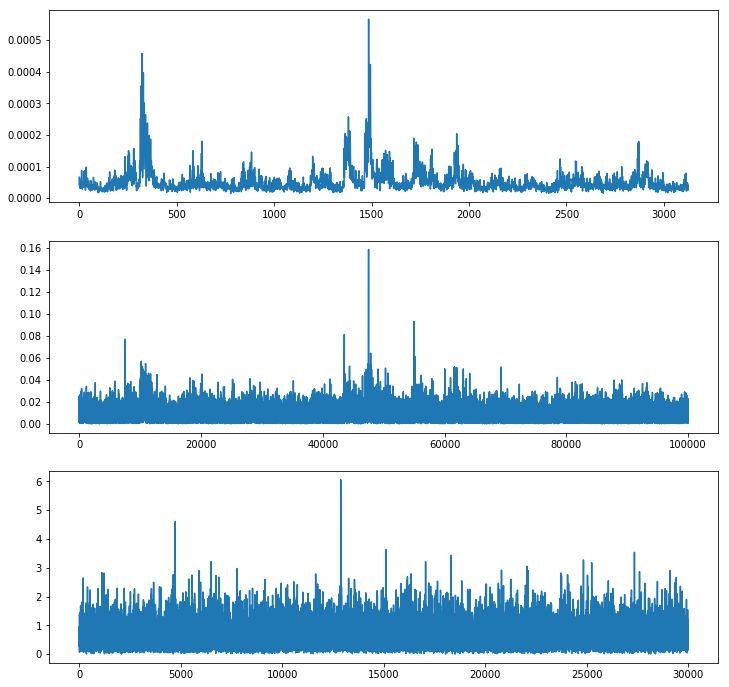

train mean = 0.008610045951989298
train std  = 0.005454419242385943
test mean = 0.6373567379906634
test std  = 0.37536842422638633
train
(0.025777579451200103, 0.062418673045062156)
(0.011082910149873003, 0.007152430520099385)
(0.009580769908068852, 0.006532928994198598)
(0.008610045951989298, 0.005454419242385943)
test
(1.2401290428091958, 0.6555280028483452)
(1.1575609070892692, 0.5097798248645098)
(0.9166099591694749, 0.5139145244012298)
(0.6373567379906634, 0.37536842422638633)
CPU times: user 58.6 s, sys: 7.73 s, total: 1min 6s
Wall time: 1min 10s


In [52]:
%%time
# training segmentation problem

net3 = Net3()
print(net3)

device    = torch.device('cuda')
model     = net3.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs   = 4
train_errors_epoch = []
test_errors_epoch  = []
best_acc = 0
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        y = y.data.cpu()
        train_errors.extend(Metrics.localization_error_regression(pred, y))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        pred = pred.data.cpu()
        y    = y.data.cpu()
        pred = sensor_input_dataset.undo_normalize(pred)
        y    = sensor_input_dataset.undo_normalize(y)
        test_errors.extend(Metrics.localization_error_regression(pred, y))
    
    clear_output(True)
    plt.figure(figsize=(12, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()

    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train')
for error in train_errors_epoch:
    print(error)
print('test')
for error in test_errors_epoch:
    print(error)

In [43]:
test_errors = []
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['label'].to(device)
    pred = model(X)
    pred = pred.data.cpu()
    y    = y.data.cpu()
    pred = sensor_input_dataset.undo_normalize(pred)
    y    = sensor_input_dataset.undo_normalize(y)
    test_errors.append(Metrics.localization_error_regression(pred, y, True))
    break

print(test_errors)

tensor([47.9957, 39.3781]) tensor([48., 40.])
tensor([65.1670, 16.2716]) tensor([65., 16.])
tensor([60.1719, 57.5186]) tensor([60.0000, 58.0000])
tensor([65.1133, 47.7108]) tensor([64., 48.])
tensor([97.0543, 28.7170]) tensor([96., 29.])
tensor([8.2286, 8.2411]) tensor([8., 9.])
tensor([81.8517, 29.9850]) tensor([81.0000, 30.0000])
tensor([98.1202, 25.8020]) tensor([98., 26.])
tensor([43.4531, 64.1887]) tensor([43., 64.])
tensor([98.6539, 43.4107]) tensor([98., 43.])
tensor([62.6550, 31.1794]) tensor([62., 31.])
tensor([50.6372, 72.8334]) tensor([51., 73.])
tensor([ 9.4330, 68.9616]) tensor([ 9., 68.])
tensor([34.5096, 96.0039]) tensor([35., 96.])
tensor([87.6219, 14.4451]) tensor([87.0000, 15.0000])
tensor([73.0239, 33.6138]) tensor([73., 33.])
tensor([36.2715, 58.3716]) tensor([36.0000, 59.0000])
tensor([24.8085, 74.4542]) tensor([25., 74.])
tensor([34.0944, 81.8990]) tensor([34., 83.])
tensor([11.9455,  8.4130]) tensor([13.,  9.])
tensor([-0.0822, 22.9796]) tensor([ 0., 22.])
tensor